<a href="https://colab.research.google.com/github/Vonewman/Natural_Language_Processing/blob/master/Time_Series_Prediction_using_LSTM_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset and Problem Definition

The dataset that we will be using comes built-in with the *Python Seaborn Library*. Let's import the required libraries first and then will import the dataset:

In [0]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's print the list of all the datasets that come built-in with the Seaborn library:

In [74]:
sns.get_dataset_names()

/usr/local/lib/python3.6/dist-packages/seaborn/utils.py:384: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 384 of the file /usr/local/lib/python3.6/dist-packages/seaborn/utils.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  gh_list = BeautifulSoup(http)


['anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'iris',
 'mpg',
 'planets',
 'tips',
 'titanic']

The dataset that we will be using is the **flights** dataset. Let's load the dataset into our application and see how it looks:

In [75]:
flight_data = sns.load_dataset('flights')
flight_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [76]:
flight_data.shape

(144, 3)

In [0]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

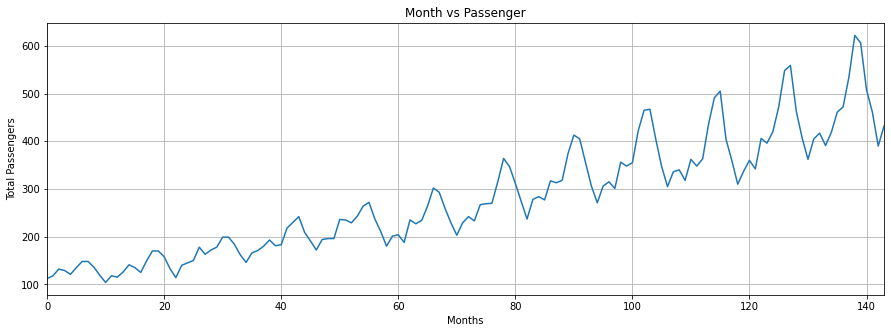

In [78]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

## Data Preprocessing

In [79]:
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

The first preprocessing step is to change the type of the *passengers* column to *float*.

In [0]:
all_data = flight_data['passengers'].values.astype(float)

In [81]:
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


Split the data into train and test dataset

In [0]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data  = all_data[-test_data_size:]

Let's now print the length of the test and train sets:

In [83]:
print(len(train_data))
print(len(test_data))

132
12


In [84]:
print(test_data)

[417. 391. 419. 461. 472. 535. 622. 606. 508. 461. 390. 432.]


Our dataset is not normalized at the moment. The total number of passengers in the initial years is far less compared to the total number of passengers in the later years. It is very important to normalize the data for time series predictions. We will perform min/max scaling on the dataset which normalizes the data within a certain range of minimum and maximum values. We will be using the MinMaxScaler class from the sklearn.preprocessing module to scale our data. For further details of the min/max scaler implementation, visit this link.

The following code normalizes our data using the min/max scaler with minimum and maximum values of -1 and 1, respectively.

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

Let's now print the first 5 and last 5 records of our normalized train data.

In [86]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


The next step is to convert our dataset into tensors since PyTorch models are trained using tensors. To convert the dataset into tensors, we can simply pass our dataset to the constructor of the FloatTensor object, as shown below:

In [0]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

The final preprocessing step is to convert our training data into sequences and corresponding labels.


In [0]:
train_window = 12

Next, we will define a function named **create_inout_sequences**. The function will accept the raw input data and will return a list of tuples. In each tuple, the first element will contain list of 12 items corresponding to the number of passengers traveling in 12 months, the second tuple element will contain one item i.e. the number of passengers in the 12+1st month.

In [0]:
def create_inout_sequences(inout_data, tw):
  inout_seq = []
  L = len(inout_data)
  for i in range(L-tw):
    train_seq = inout_data[i:i+tw]
    train_label = inout_data[i+tw:i+tw+1]
    inout_seq.append((train_seq, train_label))
  return inout_seq

In [0]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

Let's now print the first 5 items of the train_inout_seq list:

In [91]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]), tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]), tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]), tensor([-0.9077]))]

## Creating LSTM model

We have preprocessed the data, now is the time to train our model. We will define a class **LSTM**, which inherits from **nn.Module** class of the **PyTorch** library. Check out my last article to see how to create a classification model with PyTorch. That article will help you understand what is happening in the following code.

In [0]:
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
    super().__init__()
    self.hidden_layer_size = hidden_layer_size

    self.lstm = nn.LSTM(input_size, hidden_layer_size)

    self.linear = nn.Linear(hidden_layer_size, output_size)

    self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


The next step is to create an object of the LSTM() class, define a loss function and the optimizer. Since, we are solving a classification problem, we will use the cross entropy loss. For the optimizer function, we will use the adam optimizer.

In [0]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [94]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
